# Common errors

This notebook lists the errors that users may encounter during their EOScale usage.

## Accessing data outside EOScale context

EOScale data are only accessible inside the context manager : `EOContextManager`

### Problematic code

```python
from eoscale.filters.concatenate_images import concatenate_images
from eoscale.core.manager import EOContextManager

input_image_path: str = "../../../examples/data/dsm.tif"

with EOContextManager(nb_workers=4, tile_mode=True) as eoscale_manager:
    concatenate_vpath = concatenate_images(eoscale_manager, [input_image_path, input_image_path])
    arr = eoscale_manager.get_array(concatenate_vpath)
print(arr) # try to get the array outside the EOContextManager
```

will result as a segmentation fault

### Correct code

In [1]:
from eoscale.filters.concatenate_images import concatenate_images
from eoscale.core.manager import EOContextManager

input_image_path: str = "../../../examples/data/dsm.tif"

with EOContextManager(nb_workers=4, tile_mode=True) as eoscale_manager:
    concatenate_vpath = concatenate_images(eoscale_manager, [input_image_path, input_image_path])
    arr = eoscale_manager.get_array(concatenate_vpath)
    print(arr) # try to get the array inside the EOContextManager

Concatenate processing...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 633.22it/s]

[[[ 96.605194  96.23185   95.92779  ... 102.59602  102.8203   102.94064 ]
  [ 96.25583   95.99203   95.61832  ... 102.73956  103.04237  103.13515 ]
  [ 95.88425   95.547676  95.19413  ... 102.84221  103.16673  103.41429 ]
  ...
  [ 88.95522   89.72472   89.92356  ... 119.50397  119.28551  118.882324]
  [ 89.04983   89.63305   89.82265  ... 119.24495  118.877396 118.40853 ]
  [ 89.42593   89.2541    89.31284  ... 118.72969  118.34775  117.77579 ]]

 [[ 96.605194  96.23185   95.92779  ... 102.59602  102.8203   102.94064 ]
  [ 96.25583   95.99203   95.61832  ... 102.73956  103.04237  103.13515 ]
  [ 95.88425   95.547676  95.19413  ... 102.84221  103.16673  103.41429 ]
  ...
  [ 88.95522   89.72472   89.92356  ... 119.50397  119.28551  118.882324]
  [ 89.04983   89.63305   89.82265  ... 119.24495  118.877396 118.40853 ]
  [ 89.42593   89.2541    89.31284  ... 118.72969  118.34775  117.77579 ]]]


## Size mismatch in filters

EOScale user should care about filters inputs, `image_filter` and `generate_output_profiles` output list must have the same size.

### Problematic code

```python
from typing import List

import numpy as np

from eoscale.filters.concatenate_images import concatenate_images
from eoscale.core.manager import EOContextManager
from eoscale.core.eo_executors import n_images_to_m_images_filter

def add_value(input_buffers: list,
               input_profiles: list,
               params: dict) -> List[np.ndarray]:
    return [input_buffer + 2 for input_buffer in input_buffers]


def add_profile(input_profiles: list,
                params: dict) -> dict:
    return input_profiles[0] # return only the first profile


def add_filter(context: EOContextManager, inputs: List[str]):
    """
    add 2 to every images
    """
    return n_images_to_m_images_filter(inputs=inputs,
                                       image_filter=add_value,
                                       generate_output_profiles=add_profile,
                                       context_manager=context,
                                       filter_desc="Adding 2 processing...")
input_image_path = "../../../examples/data/dsm.tif"
with EOContextManager(nb_workers = 2, tile_mode = True) as eoscale_manager:
    keys = add_filter(eoscale_manager, [eoscale_manager.open_raster(input_image_path), eoscale_manager.open_raster(input_image_path)])
```

### Correct code

In [2]:
from typing import List

import numpy as np

from eoscale.filters.concatenate_images import concatenate_images
from eoscale.core.manager import EOContextManager
from eoscale.core.eo_executors import n_images_to_m_images_filter

def add_value(input_buffers: list,
               input_profiles: list,
               params: dict) -> List[np.ndarray]:
    return [input_buffer + 2 for input_buffer in input_buffers]


def add_profile(input_profiles: list,
                params: dict) -> dict:
    return input_profiles # profile for every output remains the same


def add_filter(context: EOContextManager, inputs: List[str]):
    """
    add 2 to every images
    """
    return n_images_to_m_images_filter(inputs=inputs,
                                       image_filter=add_value,
                                       generate_output_profiles=add_profile,
                                       context_manager=context,
                                       filter_desc="Adding 2 processing...")
input_image_path = "../../../examples/data/dsm.tif"
with EOContextManager(nb_workers = 2, tile_mode = True) as eoscale_manager:
    keys = add_filter(eoscale_manager, [eoscale_manager.open_raster(input_image_path), eoscale_manager.open_raster(input_image_path)])

Adding 2 processing...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 632.77it/s]


## Inplace operations

### Problematic code

First lets create a raster full of ones to simulate an input data.

In [3]:
import rasterio
from rasterio.transform import Affine
from rasterio.plot import show, show_hist

def create_raster(data: np.ndarray, output_file: str):
    top_left_x, top_left_y = 10.0, 50.0
    x_res, y_res = 0.01, 0.01
    transform = Affine.translation(top_left_x, top_left_y) * Affine.scale(x_res, -y_res)
    crs = "EPSG:4326"
    with rasterio.open(
            output_file, "w",
            driver="GTiff",
            height=data.shape[1],
            width=data.shape[2],
            count=data.shape[0],
            dtype=data.dtype,
            crs=crs,
            transform=transform
    ) as dst:
        dst.write(data)
        
ones_image_path = "../../../examples/data/ones.tif"
create_raster(np.ones((1, 512, 512)), ones_image_path) 

then create a filter which manipulate data inplace

In [4]:
from typing import List

import numpy as np

from eoscale.core.manager import EOContextManager
from eoscale.core.eo_executors import n_images_to_m_images_filter

def add_value(input_buffers: list,
              input_profiles: list,
              params: dict) -> List[np.ndarray]:
    return [np.add(input_buffer, 2, out=input_buffer) for input_buffer in input_buffers] # update input_buffer thanks to parameter 'out'


def add_profile(input_profiles: list,
                params: dict) -> dict:
    return input_profiles
                                                                                   
                                                                                   
def add_inplace_filter(context: EOContextManager, inputs: List[str]):
    """
    add 2 to every images
    """
    return n_images_to_m_images_filter(inputs=inputs,
                                       image_filter=add_value,
                                       generate_output_profiles=add_profile,
                                       context_manager=context,
                                       stable_margin=2,
                                       filter_desc="Adding 2 processing...")

Once the filter is ready, use it inside a EOContextManager context manager and write the result next to the input and visualize it.

In [5]:
def show_raster(input_image:str):
    with rasterio.open(input_image) as src:
        raster_data = src.read()
        show(src, title="Raster Data")

add_inplace_file = "../../../examples/data/ones_plus_2.tif"

with EOContextManager(nb_workers=3, tile_mode=True) as eoscale_manager:
    keys = add_inplace_filter(eoscale_manager, [eoscale_manager.open_raster(ones_image_path)])
    arr = eoscale_manager.get_array(keys[0])
    eoscale_manager.write(keys[0], add_inplace_file)
    unique, count = np.unique(arr, return_counts=True)
    for pix_val, val_occurence in zip(unique, count):
        print(f"pixel value: {pix_val}, occurence: {val_occurence}")



Adding 2 processing...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 468.86it/s]

pixel value: 3.0, occurence: 260100
pixel value: 5.0, occurence: 2032
pixel value: 7.0, occurence: 8
pixel value: 9.0, occurence: 4


As we can see, the table returned is not full of 3s, but also contains values in [5, 7, 9]. We can plot the resulting raster to see where these values are positioned.

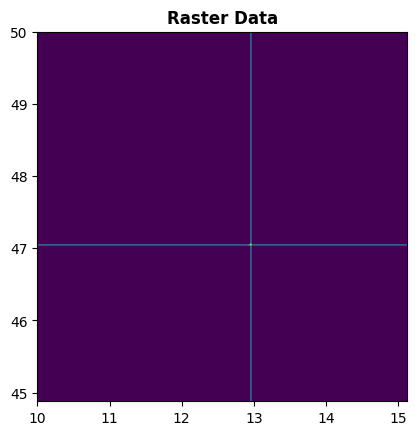

In [6]:
show_raster(add_inplace_file)

We can easily guess that the anomaly values are positioned in the overlap zone between the chunks.

### Correct code

In [7]:
from typing import List

import numpy as np

from eoscale.core.manager import EOContextManager
from eoscale.core.eo_executors import n_images_to_m_images_filter

def add_value(input_buffers: list,
              input_profiles: list,
              params: dict) -> List[np.ndarray]:
    return [np.add(input_buffer, 2) for input_buffer in input_buffers]# here 'np.add' return a copy of input_buffer


def add_profile(input_profiles: list,
                params: dict) -> dict:
    return input_profiles
                                                                                   
                                                                                   
def add_inplace_filter(context: EOContextManager, inputs: List[str]):
    """
    add 2 to every images
    """
    return n_images_to_m_images_filter(inputs=inputs,
                                       image_filter=add_value,
                                       generate_output_profiles=add_profile,
                                       context_manager=context,
                                       stable_margin=2,
                                       filter_desc="Adding 2 processing...")